# Aggregate uncertainty and heterogeneous agents: The BKM and GenBKM algorithms

Author: Julien Pascal

https://julienpascal.github.io/

Macroeconomic models with **aggregate uncertainty** and **heterogeneous agents** have been been of great interest for Economists for quite a long time. For instance, [Aiyagari (1994)](https://www.jstor.org/stable/2118417?seq=1#metadata_info_tab_contents) already hinted that taking into consideration heterogeneity along the business cycle is both theoretically important and challenging:

> This class of models may also be useful in **resolving various asset return puzzles**. Mehra and
Prescott [1985, p. 145] suggested that these puzzles cannot be "accounted for by models that abstract from transactions costs. This is a very hard problem computationally since the distribution of assets
across households can no longer be taken to be constant. Instead, **the cross-section distribution is part of the state vector that evolves stochastically over time in response to aggregate shocks**. This is an issue that remains to be explored

Recent developments have relied on the **sequence representation** of the mutli-stage decision process, instead of the traditional **recursive form** using Bellman's principle (see for instance [Auclert at al (2019)](https://web.stanford.edu/~aauclert/sequence_space_jacobian.pdf) or [Le Grand and Ragot (2019)](http://xavier-ragot.fr/pdf/progress/Optimal_policies.pdf)).

In this notebook, I present two algorithms to solve for models with aggregate uncertainty and heterogeneous agents that are both simple and fast:

* the BKM algorithm by [Boppart, Krusell and Mitman (2018)](https://ideas.repec.org/a/eee/dyncon/v89y2018icp68-92.html)
* the GenBKM algorithm by [Reiter (2018)](https://ideas.repec.org/a/eee/dyncon/v89y2018icp93-99.html).


### I.A. The BKM algorithm

It is common to use Bellman's principle of optimality to characterize solutions of a mutli-stage decision process. The principle of optimality leads to a solution in a **recursive form** $d_{t} = d(S_{t})$, where $S_t$ is a vector of state variables and d(.) a policy function describing the optimal action of a decision-maker when faced with any given state. In model with heterogeneous agents (HA) and aggregate uncertainty, $S_t$ is generally infinite-dimensional. Hence, there is a huge premium in avoiding the recursive form.

The **sequence form** of the problem is as follows: at each step in time, a decision-maker observes a new realization of a random process $z_t$ and taking into account the full history of past shocks, the agent make a new choice to maximize her expected discounted sum of returns: $d_t = d(z_t, z_{t-1}, z_{t-2}, ...)$. 

The BKM algorithm makes the **assumption** of **linearity** of d(.) with respect to the **aggregate state** $z_t$:

$$ d_t = z_t d(1, 0, 0, ...) + z_{t-1}d(0, 1, 0, ...) + z_{t-2}d(0, 0, 1, ...) + ... $$ 


where 

$$ d_{1} = d(1,0,0,...)$$
$$ d_{2} = d(0,1,0,...)$$
$$ d_{3} = d(0,0,1,...)$$

or more compactly:

$$ d_t = \sum_{k=0}^{+\infty} z_{t-k} d_{k} $$ 

The series of $d_{k}$ describes the trajectory of the economy after an "MIT" shock: the economy is hit by an aggregate shock in period 1 and then goes back directly to its steady-state value. The evolution of equilibrium variables are simply a moving average of past shocks. 

The BKM algorithm works well because computing an MIT shock in macroeconomic models with aggregate uncertainty and heterogeneous agents is generally feasible and fast. 

#### TL;DR

To simulate out-of-steady-state dynamics, the BKM algorithm superposes **scaled impulse response functions**.


### I. B. BKM example

Let's illustrate how the BKM algorithm works with the following non-linear model: 

$$ x_{t} = a x_{t-1} + b x_{t-1}^2 + z_{t} $$

where $x_{t}$ is an economic variable and $z_{t}$ a random variable that generate aggregate uncertainty.

The next plot illustrates that BKM algorithm does a good job at approximating the dynamic of the true
nonlinear model. But can we do better? The next section shows that the answer is yes.

  0.011797 seconds (33.70 k allocations: 1.774 MiB)


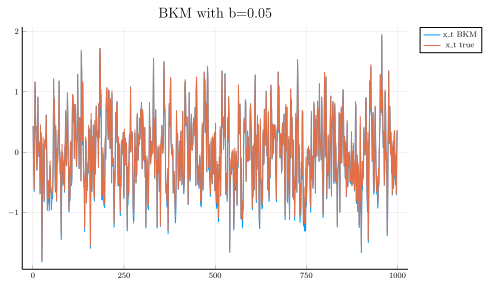

In [1]:
# Dependencies
using Distributions
using Plots
using DataFrames
using Random
pgfplotsx()

# Parameters
max_iter=1000 #number of iterations for the simulation
a = 0.5
b = 0.05
sigma_shock=1.0 #variance of shocks
mu_shock=0. #mean of shocks
Random.seed!(1234)
d = Normal(mu_shock, sigma_shock)

# transition function
function iter_x(x_min1::Float64, a::Float64, b::Float64)
    """
    Function to find the next iteration of x_{t} = a x_{t-1} + b x_{t-1}^2
    x_min1::Float64: x_{t-1}
    a::Float64 
    b::Float64 
    """
    return a*x_min1 + b*x_min1^2
end

# Simulation of an MIT Shock
# We assume that after max_iter_mit periods, the economy is back at the steady-state
max_iter_mit = 25
x_mit=zeros(max_iter_mit)
# Initial shock
z_t=zeros(max_iter_mit)
z_t[1] = sigma_shock #a 1 std. deviation
x_mit[1] = 0 #steady-state

for i=2:max_iter_mit
    x_mit[i] = iter_x(x_mit[i-1], a, b) + z_t[i-1]
end

# Scaled-version of the impulse response:
x_mit_scaled = x_mit./z_t[1];

# Scaled-version of the impulse response:
p0 = plot(x_mit_scaled, label="x scaled", xlabel="t")
title!("MIT shock")

# Function to calculate the path of xt using the BKM algorithm
function BKM_path!(XT::Array{Float64,1}, x_scaled::Array{Float64,1}, shocks::Array{Float64,1})
    """
    XT::Array{Float64,1}: array to store the evolution of the variable xt
    x_scaled::Array{Float64,1}: a scaled MIT shock
    shocks::Array{Float64,1}: sequence of shocks
    """
    # get the length of x_scaled
    len_x_scaled = length(x_scaled)
    max_iter = length(XT)
    
    # Loop over time periods periods
    for t=2:max_iter
        # Superposition of MIT shocks:
        for k=1:t
            # After some time, we assume that the effect of past shocks vanishes:
            if k<=len_x_scaled
                XT[t]+=x_scaled[k]*shocks[t-k+1]
            end
        end
    end
    
end

XT = zeros(max_iter) # Initialization
shocks_t = rand(d, max_iter).*0.5 # Series of shocks
@time BKM_path!(XT, x_mit_scaled, shocks_t) # Solving using BKM:
x_true = zeros(max_iter) # True value of the series
for i=2:max_iter
    x_true[i] = iter_x(x_true[i-1], a, b) + shocks_t[i-1]
end

# Let's store statistics on error:
diff_BKM = x_true - XT
max_abs_err_BKM = maximum(abs.(diff_BKM))
min_abs_err_BKM = minimum(abs.(diff_BKM))
mean_abs_err_BKM = mean(abs.(diff_BKM))
median_abs_err_BKM = median(abs.(diff_BKM))

p1 = plot(XT[2:end], label="x_t BKM")
plot!(x_true[2:end], label="x_t true")
title!("BKM with b=$(b)")
p1

*Notes: In orange the exact value as a function of time; in blue the approximation obtained by using
the BKM algorithm*

### II. A. The GenBKM algorithm

The BKM algorithm is based on the assumption that both the **size** and **sign** of the initial shock does not
change the shape of the scaled impulse response function. But is really the case? The next graph shows that both the size and the sign matter for the shape of the scaled impulse response function:

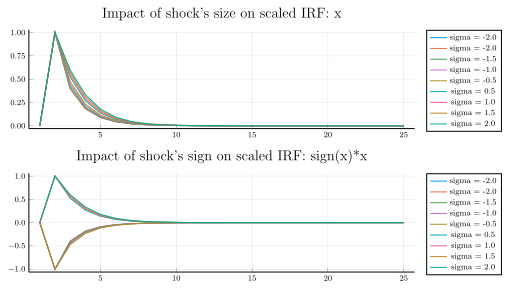

In [2]:
# Different initial shocks
array_sigma = collect(range(-2, stop=2, step=0.5))
# Let's exclude sigma = 0
array_sigma = array_sigma[array_sigma .!= 0.]
# To store the different scaled IRF:
x_mit_scaled_sigma = zeros(max_iter_mit, length(array_sigma)) 

for (index_sigma, sigma) in enumerate(array_sigma)
    x_mit=zeros(max_iter_mit)
    # Initial shock
    z_t=zeros(max_iter_mit)
    z_t[1] = sigma #a 1 std. deviation
    x_mit[1] = 0 #steady-state

    for i=2:max_iter_mit
        x_mit[i] = iter_x(x_mit[i-1], a, b) + z_t[i-1]
    end

    # Scaled-version of the impulse response:
    x_mit_scaled = x_mit./z_t[1];
    # store the scaled response
    x_mit_scaled_sigma[:, index_sigma] = x_mit_scaled
    
end


p2 = plot(x_mit_scaled_sigma[:, 1], label="sigma = $(array_sigma[1])")
p3 = plot(sign(array_sigma[1])*x_mit_scaled_sigma[:, 1], label="sigma = $(array_sigma[1])")

for (index_sigma, sigma) in enumerate(array_sigma)
    plot!(p2, x_mit_scaled_sigma[:, index_sigma], label="sigma = $(sigma)", title = "Impact of shock's size on scaled IRF: x")
    plot!(p3, sign(sigma)*x_mit_scaled_sigma[:, index_sigma], label="sigma = $(sigma)", title = "Impact of shock's sign on scaled IRF: sign(x)*x")
end

p4 = plot(p2, p3, layout = (2, 1))
p4

*Notes: The top panel shows the scaled impulse response function for different
values of shocks. The bottom panel shows the scaled impulse response function
multiplied by the sign of the shock. If the size and the sign of the shock did not matter, we would
see only one line. It is not the case here.*

The GenBKM algorithm is the similar to the BKM algorithm, except that the impacts of the size and the sign of the 
initial shock on the response of the economy are taken into consideration. It proceeds as follows:

1. Divide the support of the shock into $n$ intervals $ I_i = (a_i, b_i)$
2. Compute $n$ MIT shocks using shocks in $z_i \in I_i$, denoted by $d_k^{i}$
3. The state of the economy at time $t$ is given by the moving average of past shocks, taking into consideration
past shock values:

$$ d_t = \sum_{k=0}^{+\infty} z_{t-k} d_{k}^{f(t-k)} $$ 

where the function $f(t)$ returns the index of the interval in which the shock $z_t$ falls. 

#### TL;DR

**GenBKM = BKM with different scaled IRF, instead of one.**

### II. B. GenBKM example

The GenBKM algorithm is implemented in the block of code that follows. The next plot shows that the approximation error is much smaller using the GenBKM algorithm. The next table shows that the mean absolute error drops by more than 300% if the GenBKM is used instead of BKM.

  0.189805 seconds (1.16 M allocations: 55.378 MiB)


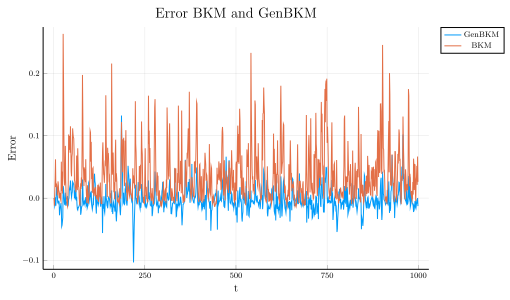

In [3]:
function GenBKM_path!(XT::Array{Float64,1}, x_scaled::Array{Float64,2}, shocks::Array{Float64,1}, array_sigma::Array{Float64,1})
    """
    XT::Array{Float64,1}: array to store the evolution of the variable xt
    x_scaled::Array{Float64,2}: scaled MIT shocks. Each column corresponds to one scaled MIT shocks.
    shocks::Array{Float64,1}: sequence of shocks
    array_sigma::Array{Float64,1}: grid of shocks used to simulate x_scaled
    """
    # get the length of x_scaled
    len_x_scaled = size(x_scaled,1)
    max_iter = length(XT) 
    
    # We don't want x_scaled to contain any NaN value
    if sum(isnan.( x_scaled) .== true) != 0
        error("x_scaled contains at least one NaN value.")
    end
    
    # We don't want shocks to contain any NaN value
    if sum(isnan.(shocks) .== true) != 0
        error("shocks contains at least one NaN value.")
    end
    
    # Loop over time periods periods
    for t=2:max_iter
        # Superposition of MIT shocks:
        for k=1:t
            # After some time, we assume that the effect of past shocks vanishes:
            if k<=len_x_scaled
                # Find were the initial shock stood on the sigma grid:
                index_sigma = searchsortednearest(array_sigma, shocks[t-k+1])
                XT[t]+=x_scaled[k, index_sigma]*shocks[t-k+1]
            end
        end
    end
    
end

# Function to find the index corresponding to the closest value on a grid:
# Source: https://discourse.julialang.org/t/findnearest-function/4143/4
function searchsortednearest(a::Array{Float64,1},x::Float64)
    """
    a::Array{Float64,1}: grid
    x::Float64: value to be found
    returns the index of the closest value to x on grid a
    """
    idx = searchsortedfirst(a,x)
    if (idx==1); return idx; end
    if (idx>length(a)); return length(a); end
    if (a[idx]==x); return idx; end
    if (abs(a[idx]-x) < abs(a[idx-1]-x))
      return idx
    else
      return idx-1
    end
end

# Calculation of GenBKM path:
XT_GenBKM = zeros(max_iter);
@time GenBKM_path!(XT_GenBKM, x_mit_scaled_sigma, shocks_t, array_sigma)

# Let's store statistics on error:
diff_GenBKM = x_true - XT_GenBKM
max_abs_err_GenBKM = maximum(abs.(diff_GenBKM))
min_abs_err_GenBKM = minimum(abs.(diff_GenBKM))
mean_abs_err_GenBKM = mean(abs.(diff_GenBKM))
median_abs_err_GenBKM = median(abs.(diff_GenBKM))

df = DataFrame(Statistics = ["Max absolute error", "Min absolute error", "Mean absolute error", "Median absolute error"],
               BKM = [max_abs_err_BKM, min_abs_err_BKM, mean_abs_err_BKM, median_abs_err_BKM],
               GenBKM = [max_abs_err_GenBKM, min_abs_err_GenBKM, mean_abs_err_GenBKM, median_abs_err_GenBKM])

# Plot errors
p6 = plot(diff_GenBKM[2:end], label="GenBKM", xlabel = "t", ylabel = "Error")
plot!(diff_BKM[2:end], label="BKM")
title!("Error BKM and GenBKM")

# Display graph:
p6

*Notes: In orange the approximation error when using BKM; in blue the approximation error when using GenBKM*

In [4]:
df

4×3 DataFrame
│ Row │ Statistics            │ BKM       │ GenBKM    │
│     │ String                │ Float64   │ Float64   │
├─────┼───────────────────────┼───────────┼───────────┤
│ 1   │ Max absolute error    │ 0.263167  │ 0.132318  │
│ 2   │ Min absolute error    │ 0.0       │ 0.0       │
│ 3   │ Mean absolute error   │ 0.0381089 │ 0.0136915 │
│ 4   │ Median absolute error │ 0.0237194 │ 0.0100031 │

### Conclusion

Heterogeneity along the business cycle matters. This notebook presented two simple algorithms that are both fast and accurate to solve for macroeconomics models with heterogeneous agents. GenBKM is a refinement of BKM, which tends to be more accurate. However, there is no free lunch. The increased accuracy of GenBKM is obtained by using several MIT shocks instead of one. 

## References

* Aiyagari, S. Rao. "Uninsured idiosyncratic risk and aggregate saving." The Quarterly Journal of Economics 109.3 (1994): 659-684.
* Auclert, Adrien, et al. Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models. No. w26123. National Bureau of Economic Research, 2019.
* Boppart, Timo, Per Krusell, and Kurt Mitman. "Exploiting MIT shocks in heterogeneous-agent economies: the impulse response as a numerical derivative." Journal of Economic Dynamics and Control 89 (2018): 68-92.
* Le Grand, François, and Ragot, Xavier. "Managing Inequality over the Business Cycles: Optimal Policies with Heterogeneous Agents and Aggregate Shocks". No. 1090. Society for Economic Dynamics, 2019.
* Reiter, Michael. "Comments on" Exploiting MIT Shocks in Heterogeneous-Agent Economies: The Impulse Response as a Numerical Derivative" by T. Boppart, P. Krusell and K. Mitman." Journal of Economic Dynamics and Control 89 (2018): 93-99.

## Appendix

In [5]:
versioninfo()

Julia Version 1.3.0
Commit 46ce4d7933 (2019-11-26 06:09 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


-----

Originally published at https://julienpascal.github.io on April 21, 2020.